# 阻塞IO(blocking IO)
在linux中，默认情况下所有的socket都是blocking，一个典型的读操作流程大概是这样：
 
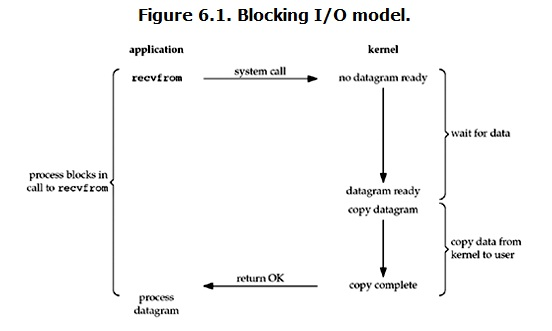


当用户进程调用了recvfrom这个系统调用，kernel就开始了IO的第一个阶段：
 
1. 准备数据。对于network io来说，很多时候数据在一开始还没有到达（比如，还没有收到一个完整的UDP包），这个时候kernel就要等待足够的数据到来。

2. 而在用户进程这边，整个进程会被阻塞。

3. 当kernel一直等到数据准备好了，它就会将数据从kernel中拷贝到用户内存，

4. 然后kernel返回结果，用户进程才解除block的状态，重新运行起来。

所以，blocking IO的特点就是在IO执行的两个阶段（等待数据和拷贝数据两个阶段）都被block了。

几乎所有的程序员第一次接触到的网络编程都是从listen()、send()、recv() 等接口开始的，</br>
使用这些接口可以很方便的构建服务器/客户机的模型。然而大部分的socket接口都是阻塞型的。如下图

ps：所谓阻塞型接口是指系统调用（一般是IO接口）不返回调用结果并让当前线程一直阻塞，只有当该系统调用获得结果或者超时出错时才返回。

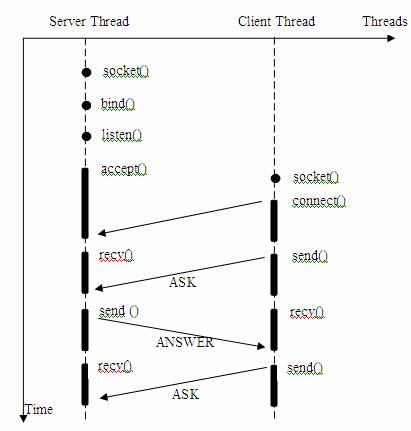

实际上，除非特别指定，几乎所有的IO接口 ( 包括socket接口 ) 都是阻塞型的。

这给网络编程带来了一个很大的问题，如在调用recv(1024)的同时，线程将被阻塞，在此期间，线程将无法执行任何运算或响应任何的网络请求。

一个简单的解决方案：

- 在服务器端使用多线程（或多进程）。多线程（或多进程）的目的是让每个连接都拥有独立的线程（或进程），</br>
这样任何一个连接的阻塞都不会影响其他的连接。

该方案的问题是：

- 开启多进程或都线程的方式，在遇到要同时响应成百上千路的连接请求，则无论多线程还是多进程都会严重占据系统资源，</br>
降低系统对外界响应效率，而且线程与进程本身也更容易进入假死状态。

改进方案：

- 很多程序员可能会考虑使用“线程池”或“连接池”。“线程池”旨在减少创建和销毁线程的频率，</br>
其维持一定合理数量的线程，并让空闲的线程重新承担新的执行任务。</br>
“连接池”维持连接的缓存池，尽量重用已有的连接、减少创建和关闭连接的频率。</br>
这两种技术都可以很好的降低系统开销，都被广泛应用很多大型系统，如websphere、tomcat和各种数据库等。

改进后方案其实也存在着问题：

- “线程池”和“连接池”技术也只是在一定程度上缓解了频繁调用IO接口带来的资源占用。</br>
而且，所谓“池”始终有其上限，当请求大大超过上限时，“池”构成的系统对外界的响应并不比没有池的时候效果好多少。</br>
所以使用“池”必须考虑其面临的响应规模，并根据响应规模调整“池”的大小。

***对应上例中的所面临的可能同时出现的上千甚至上万次的客户端请求，“线程池”或“连接池”或许可以缓解部分压力，但是不能解决所有问题。</br>
总之，多线程模型可以方便高效的解决小规模的服务请求，但面对大规模的服务请求，多线程模型也会遇到瓶颈，可以用非阻塞接口来尝试解决这个问题。***
